<a href="https://colab.research.google.com/github/kamilakhtar015/Machine-Learning---Concepts-GSU-/blob/main/UrbanSceneSegmentation_DeepLabV3_Cityscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

balraj98_cityscapes_pix2pix_dataset_path = kagglehub.dataset_download('balraj98/cityscapes-pix2pix-dataset')
kamilakhtar_picture_01_path = kagglehub.dataset_download('kamilakhtar/picture-01')
kamilakhtar_talking_man_picture_path = kagglehub.dataset_download('kamilakhtar/talking-man-picture')
kamilakhtar_deeplabv3_model_other_default_1_path = kagglehub.model_download('kamilakhtar/deeplabv3-model/Other/default/1')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cityscapes-pix2pix-dataset/metadata.csv
/kaggle/input/cityscapes-pix2pix-dataset/val/208.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/473.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/333.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/45.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/369.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/56.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/89.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/20.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/275.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/212.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/239.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/58.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/150.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/6.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/109.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/149.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/187.jpg
/kaggle/input/cityscapes-pix2pix-dataset/val/436.jpg

In [ ]:
print("Let Begin the Segmentation")

Let Begin the Segmentation


In [ ]:
# Notebook Title
# Urban Scene Segmentation Using DeepLabV3+ on Cityscapes Dataset

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython.display import display

dataset_path = '/kaggle/input/cityscapes-dataset'

# Check the directory structure
for root, dirs, files in os.walk(dataset_path):
    print(root)
    for file in files[:5]:
        print('  └──', file)
    print()


In [ ]:
data_dir = "/kaggle/input/cityscapes-pix2pix-dataset"

train_dir = os.path.join(data_dir, 'train')
val_dir= os.path.join(data_dir, 'val')

print("Sample training images")
train_files = sorted(os.listdir(train_dir))
for file in train_files[:6]:
    print(file)

print("___________________________________________________________")

print("Training Dataset length " , len(train_files))
test_files = os.listdir(val_dir)
print("Test Dataset length " , len(test_files))

Sample training images
1.jpg
10.jpg
100.jpg
1000.jpg
1001.jpg
1002.jpg
___________________________________________________________
Training Dataset length  2975
Test Dataset length  500


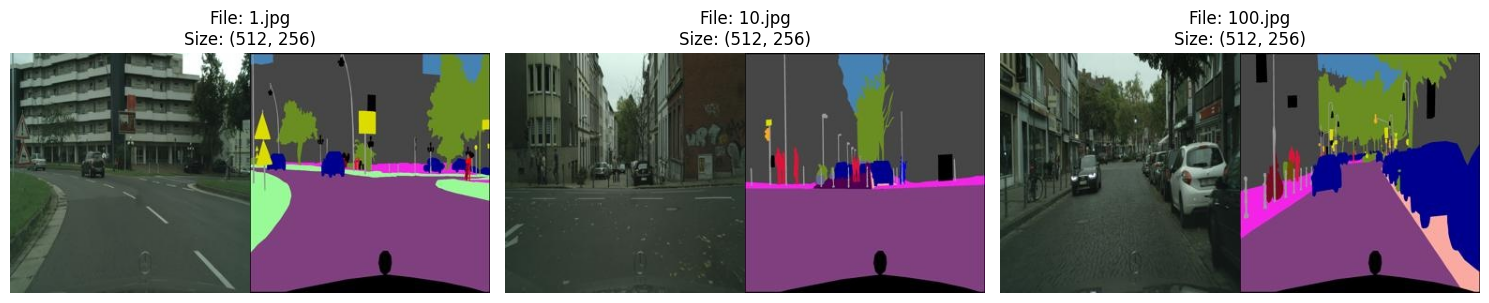

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os

train_dir = '/kaggle/input/cityscapes-pix2pix-dataset/train'

# Load a few samples
sample_files = sorted(os.listdir(train_dir))[:3]

plt.figure(figsize=(15, 5))
for idx, file in enumerate(sample_files):
    path = os.path.join(train_dir, file)
    img = Image.open(path)

    plt.subplot(1, 3, idx+1)
    plt.imshow(img)
    plt.title(f"File: {file}\nSize: {img.size}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Data Preprocessing

### Split Image into Input and Mask

In [ ]:
# Split image into Input and Mask
from PIL import Image
import numpy as np

def load_image_and_mask(path):
    """
    Loads a 512x256 pix2pix image, splits it into input (RGB) and mask (RGB)
    """
    img = Image.open(path)
    img_array = np.array(img)

    # Split into input and mask (split along width)
    input_img = img_array[:, :256,:] / 255  #  Normalize to [0, 1]
    mask_img = img_array[: ,256:, :]        # Keep as raw labels

    return input_img, mask_img

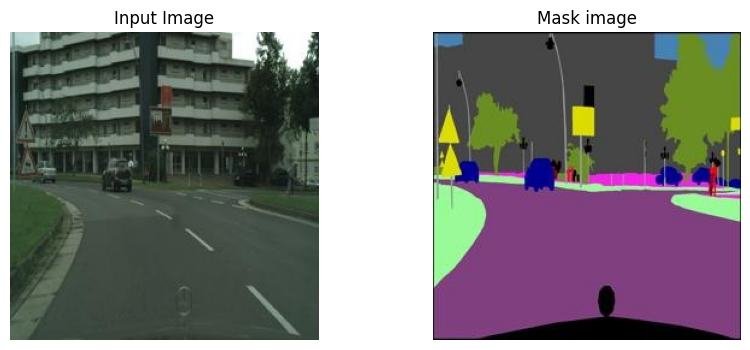

In [ ]:
# Preview input and mask split
sample_file = os.path.join(train_dir, '1.jpg')

input_img, mask_img = load_image_and_mask(sample_file)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(input_img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mask_img)
plt.title("Mask image")
plt.axis("off")

plt.show()

### Define Color-to-Class Mapping

In [ ]:
# Define a color -> class ID mapping (you can expand this based on visual inspection)
COLOR_MAP = {
    (128, 64, 128): 0,   # road
    (244, 35, 232): 1,   # sidewalk
    (70, 70, 70): 2,     # building
    (102, 102, 156): 3,  # wall
    (190, 153, 153): 4,  # fence
    (153, 153, 153): 5,  # pole
    (250, 170, 30): 6,   # traffic light
    (220, 220, 0): 7,    # traffic sign
    (107, 142, 35): 8,   # vegetation
    (0, 0, 142): 9       # car
}


### Convert RGB Mask to Class Index Mask

In [ ]:
def rgb_to_class(mask_img):
    """
    Converts RGB mask to a single-channel mask of class IDs.
    """
    h, w, _ = mask_img.shape
    class_mask = np.zeros((h, w), dtype=np.uint8)  # ✅ Fix typo: np.uint8

    for color, class_id in COLOR_MAP.items():
        matches = np.all(mask_img == color, axis=-1)
        class_mask[matches] = class_id

    return class_mask


### Final Preprocessing Function

In [ ]:
def preprocess_image(file_path):
    input_img, mask_img = load_image_and_mask(file_path)
    class_mask = rgb_to_class(mask_img)
    return input_img, class_mask

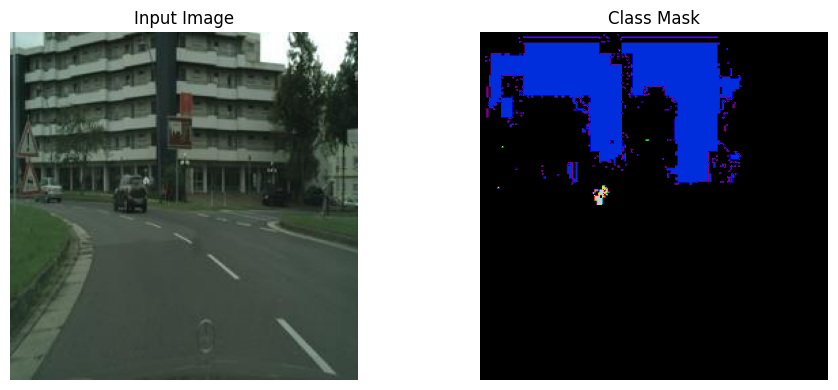

In [ ]:
test_file = os.path.join(train_dir, "1.jpg")

input_img, mask = preprocess_image(test_file)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(input_img)
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="nipy_spectral")
plt.title("Class Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Build the Dataset Loader

### tf.data.Dataset Pipeline

In [ ]:
import tensorflow as tf

def tf_preprocess(file_path):
    def _py_function(path):
        path_str = path.numpy().decode()
        input_img, mask = preprocess_image(path_str)
        return input_img, mask

    image, mask = tf.py_function(_py_function, [file_path], [tf.float32, tf.uint8])
    image.set_shape([256, 256, 3])
    mask.set_shape([256, 256])

    return image, mask

def get_dataset(folder_path, batch_size=8, shuffle=True):
    image_files = sorted([os.path.join(folder_path, fname) for fname in os.listdir(folder_path)])

    dataset = tf.data.Dataset.from_tensor_slices(image_files)
    dataset = dataset.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


### Create Train & Validation Datasets

In [ ]:
train_dataset = get_dataset(train_dir, batch_size=8)
val_dataset = get_dataset(val_dir, batch_size=8, shuffle=False)

# Check one batch
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)


Image batch shape: (8, 256, 256, 3)
Mask batch shape: (8, 256, 256)


# Model Architecture — DeepLabV3+

### Set Number of Classes

In [ ]:
NUM_CLASSES = len(COLOR_MAP)

In [ ]:
def DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=10):
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use intermediate feature map
    x = base_model.get_layer("conv4_block23_out").output  # 1/16 resolution
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # ASPP-like bottleneck
    x = layers.Conv2D(256, 1, dilation_rate=1, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    # Upsample to 1/4 resolution
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Final decoder layers
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    # Output layer
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model


In [ ]:
model = DeeplabV3Plus(input_shape=(256, 256, 3), num_classes=NUM_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 30,383,882 (115.91 MB)

 Trainable params: 30,299,786 (115.58 MB)

 Non-trainable params: 84,096 (328.50 KB)

# Define Callbacks

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint_cb = ModelCheckpoint(
    "best_model.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [checkpoint_cb, reduce_lr_cb]


### Train the Model

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.8433 - loss: 1.2721
Epoch 1: val_loss improved from inf to 0.72213, saving model to best_model.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 173s 462ms/step - accuracy: 0.8435 - loss: 1.2712 - val_accuracy: 0.8804 - val_loss: 0.7221 - learning_rate: 1.0000e-04
Epoch 2/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9446 - loss: 0.4901
Epoch 2: val_loss improved from 0.72213 to 0.47303, saving model to best_model.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 120s 319ms/step - accuracy: 0.9446 - loss: 0.4899 - val_accuracy: 0.9113 - val_loss: 0.4730 - learning_rate: 1.0000e-04
Epoch 3/20
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9524 - loss: 0.2676
Epoch 3: val_loss improved from 0.47303 to 0.32628, saving model to best_model.keras
372/372 ━━━━━━━━━━━━━━━━━━━━ 119s 317ms/step - accuracy: 0.9524 - loss: 0.2675 - val_accuracy: 0.9458 - val_loss: 0.3263 - learning_rate: 1.0000e-04
Epoch 4/20
372/372 ━━━━━━━━━━━━━━━━━━━

# Prediction and Visualization

### Define Color Decode Function

In [ ]:
def decode_segmentation(mask):
    """
    Converts a 2D class index mask to RGB for visualization.
    """
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for color, class_id in COLOR_MAP.items():
        rgb_mask[mask == class_id] = color

    return rgb_mask


### Predict on One Batch from Validation Set

In [ ]:
# Grab one batch from validation set
for images, true_masks in val_dataset.take(1):
    preds = model.predict(images)
    break

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


### Visualize Predictions

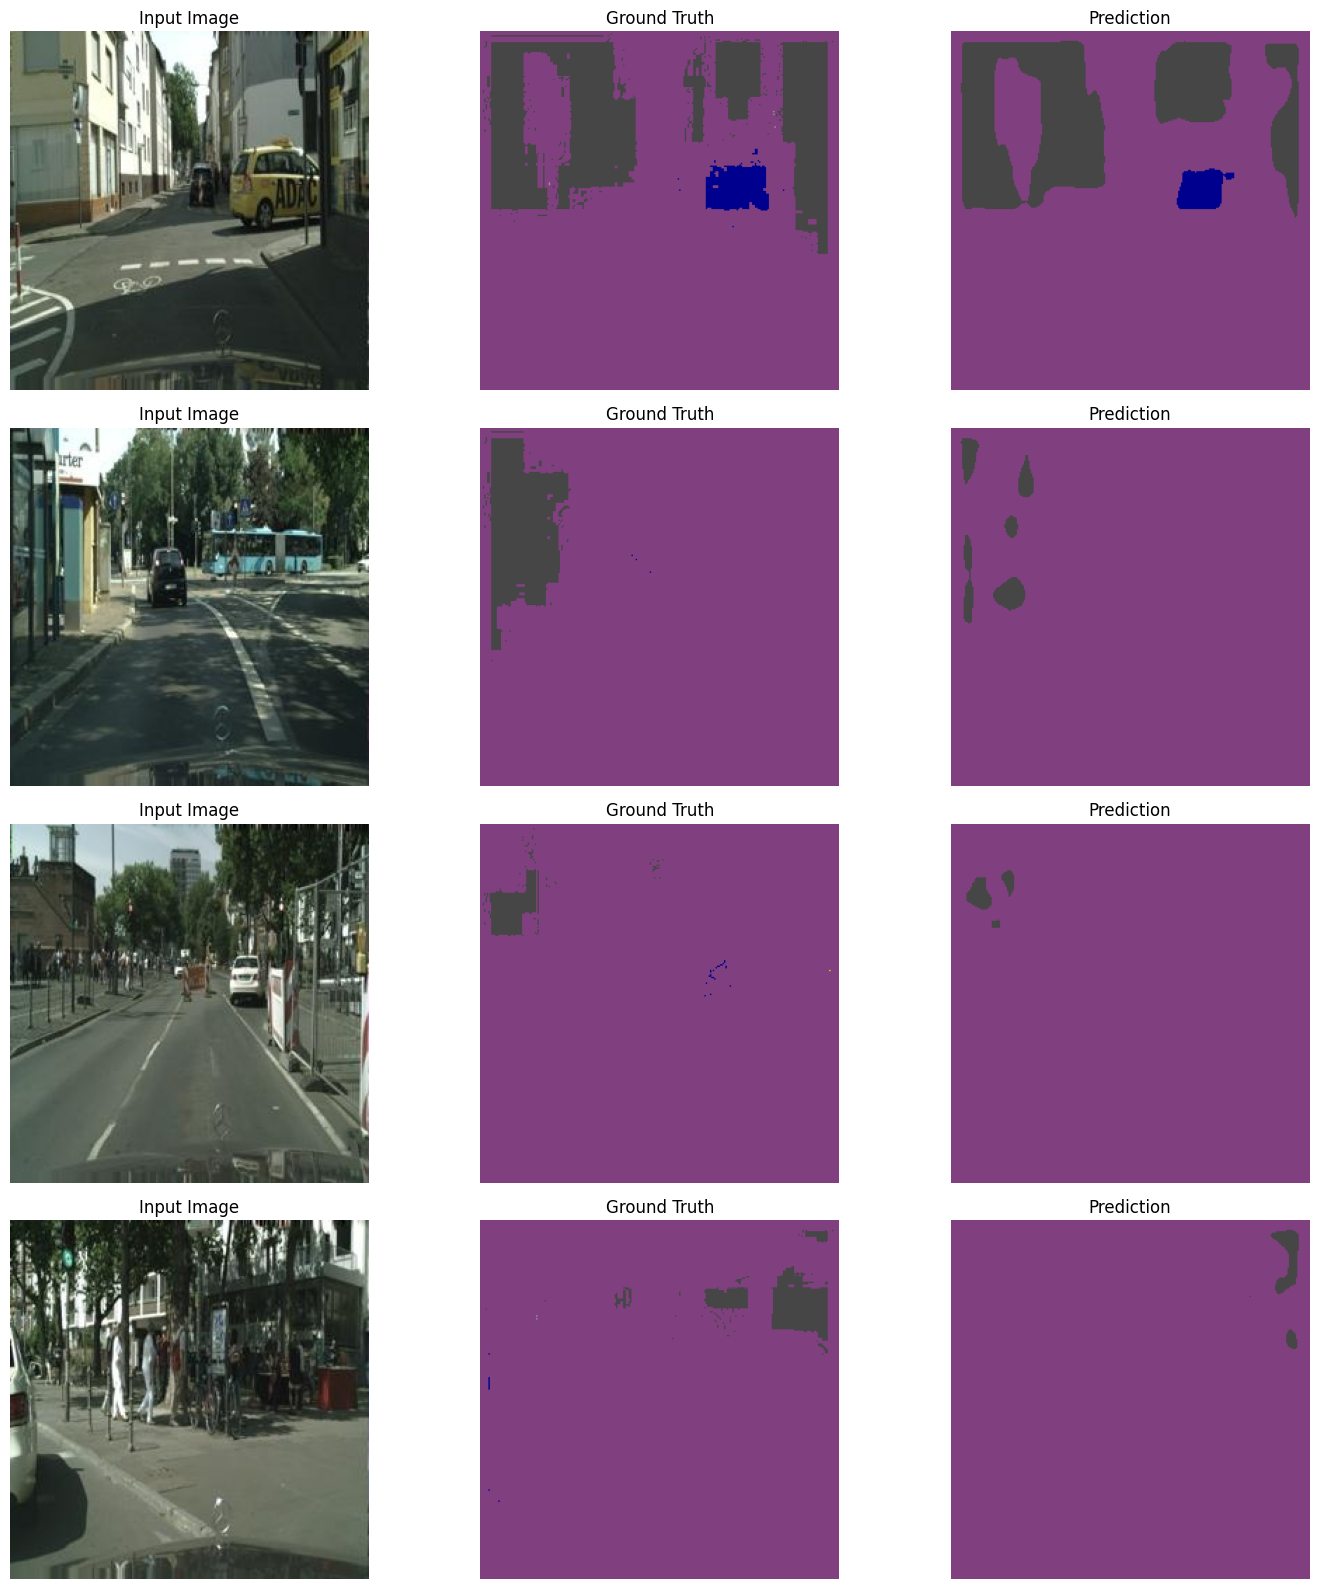

In [ ]:
num_samples = 4  # Show 4 predictions

plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    pred_mask = tf.argmax(preds[i], axis=-1).numpy()
    pred_rgb = decode_segmentation(pred_mask)
    true_rgb = decode_segmentation(true_masks[i].numpy())

    # Original
    plt.subplot(num_samples, 3, i*3 + 1)
    plt.imshow(images[i].numpy())
    plt.title("Input Image")
    plt.axis("off")

    # Ground Truth
    plt.subplot(num_samples, 3, i*3 + 2)
    plt.imshow(true_rgb)
    plt.title("Ground Truth")
    plt.axis("off")

    # Predicted
    plt.subplot(num_samples, 3, i*3 + 3)
    plt.imshow(pred_rgb)
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
model.save("road_scene_segmenter.keras")

In [ ]:
import tensorflow as tf

model_path = "/kaggle/input/deeplabv3-model/other/default/1/road_scene_segmenter.keras"
model = tf.keras.models.load_model(model_path)

print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


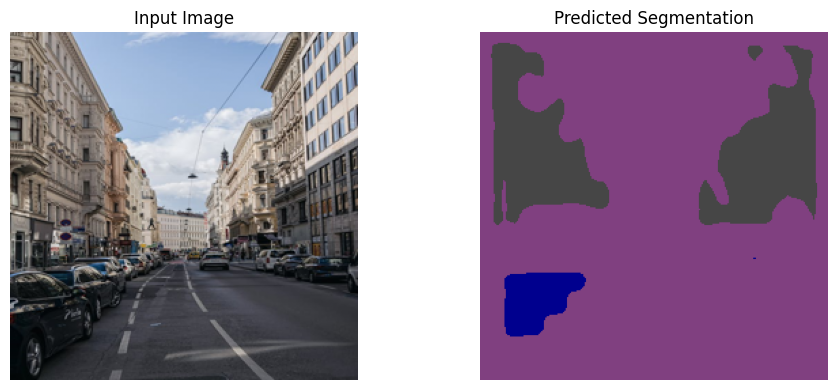

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Path to your uploaded image
image_path = "/kaggle/input/picture-01/free-photo-of-cars-parked-on-street-in-city.jpeg"

# Function to convert class index mask to RGB color
def decode_segmentation(mask):
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for color, class_id in COLOR_MAP.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

# Function to preprocess and predict segmentation
def predict_image(image_path):
    # Load and resize image
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_np = np.array(img) / 255.0  # Normalize
    img_input = np.expand_dims(img_np, axis=0)

    # Predict
    pred = model.predict(img_input)[0]
    pred_mask = tf.argmax(pred, axis=-1).numpy()
    pred_rgb = decode_segmentation(pred_mask)

    # Show result
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_rgb)
    plt.title("Predicted Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run prediction on the uploaded image
predict_image(image_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


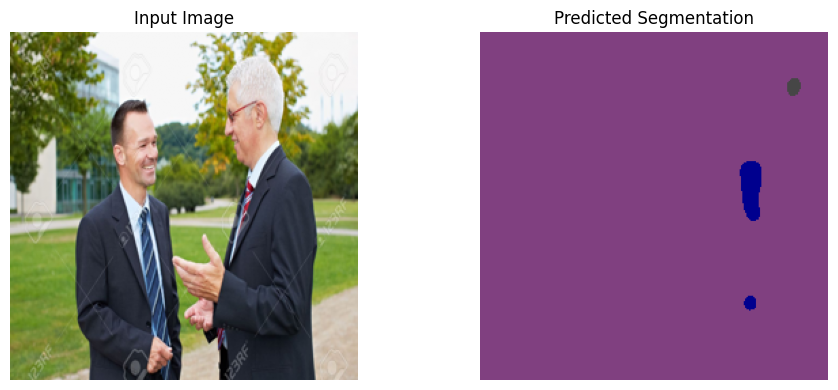

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Path to your uploaded image
image_path = "/kaggle/input/talking-man-picture/talking  men.jpg"

# Function to convert class index mask to RGB color
def decode_segmentation(mask):
    h, w = mask.shape
    rgb_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for color, class_id in COLOR_MAP.items():
        rgb_mask[mask == class_id] = color
    return rgb_mask

# Function to preprocess and predict segmentation
def predict_image(image_path):
    # Load and resize image
    img = Image.open(image_path).convert("RGB").resize((256, 256))
    img_np = np.array(img) / 255.0  # Normalize
    img_input = np.expand_dims(img_np, axis=0)

    # Predict
    pred = model.predict(img_input)[0]
    pred_mask = tf.argmax(pred, axis=-1).numpy()
    pred_rgb = decode_segmentation(pred_mask)

    # Show result
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_rgb)
    plt.title("Predicted Segmentation")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Run prediction on the uploaded image
predict_image(image_path)

